shape of data (10000, 2)


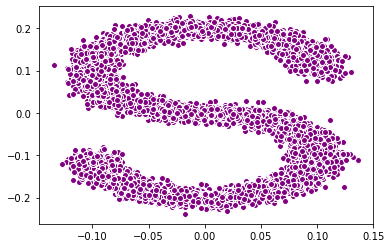

In [1]:
"""
Author: Kaikai Zhao
Reference: 
Denoising diffusion probabilistic models. https://arxiv.org/abs/2006.11239
https://www.bilibili.com/video/BV1b541197HX/?spm_id_from=333.788&vd_source=295aeb7cc6407338dd3e15d41a6b90ed
"""

# let plots display in the notebook itself instead of popping up on the screen
%matplotlib inline 
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt

s_curve, _ = make_s_curve(10**4, noise=0.1) # make 10000 data points
s_curve = s_curve[:,[0,2]]/10 # take two features of the data

print("shape of data", s_curve.shape)
data = s_curve.T
fig,ax = plt.subplots()
ax.scatter(*data, color="purple", edgecolor="white")

In [2]:
import torch
dataset = torch.tensor(s_curve).float() # transform our data into the form of torch tensor

## Determine the value of hyperparameters
### According to the following formula, we need to set the number of steps, $T$, such that $\bar{\alpha}_{T}\approx 0$, in which case $p(\mathbf{x}_{T})$ is roughly like $\mathcal{N}(\mathbf{0},\mathbf{1})$.
\begin{equation}\label{DDPM-4-q-x-t-conditioned-on-x-0}\tag{DDPM-4}
q\left(\mathbf{x}_{t} \mid \mathbf{x}_{0}\right)=\mathcal{N}\left(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0},\left(1-\bar{\alpha}_{t}\right) \mathbf{I}\right)
\end{equation}
To do this, we employ sigmoid function to generate a sequence of $\beta$'s, starting with $10^{-5}$ and ending at $0.05$.

In [3]:
# Initialization of hyperparameters

# The number of steps is supposed to be large to ensure that 1. beta_t is small and 2. x_0 is diffused to noise at the end.
num_steps = 100 
# initialize beta
beta_min = 1e-5
beta_max = 5e-2
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas)*(beta_max-beta_min) + beta_min
# initialize alpha
alphas = 1 - betas
alphas_sqrt = torch.sqrt(alphas)
alphas_bar = torch.cumprod(alphas, 0) # product of alphas
alphas_bar_sqrt = torch.sqrt(alphas_bar)
one_minus_alphas_bar_sqrt =  torch.sqrt(1 - alphas_bar)

In [4]:
# For the forward process, the following func is used to get x_t at arbitrary t. Basically, we just apply DDPM-4.
def q_x(x_0, t):
    noise = torch.randn_like(x_0)
    return alphas_bar_sqrt[t]*x_0 + one_minus_alphas_bar_sqrt[t]*noise # add noise according to DDPM-4

CPU times: total: 2.61 s
Wall time: 2.6 s


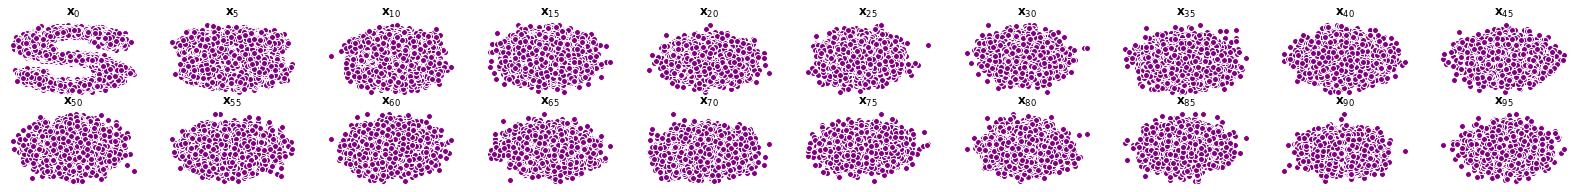

In [5]:
%%time
# show the effect of adding noise
num_shows = 20 # number of subplots
fig, ax = plt.subplots(2,10,figsize=(28,3))
plt.rc('text', color='black')

for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset, torch.tensor(i*num_steps//num_shows)) # get q_x every num_steps/num_shows steps
    ax[j,k].scatter(*q_i.T,  color="purple", edgecolor="white")
    ax[j,k].set_axis_off()
    ax[j,k].set_title('$\mathbf{x}_{' +str(i*num_steps//num_shows)+ '}$')

In [6]:
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,n_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.Linears = nn.ModuleList(
            [
                nn.Linear(2, n_units), nn.Softplus(),
                nn.Linear(n_units, n_units), nn.Softplus(),
                nn.Linear(n_units, n_units), nn.Softplus(),
                nn.Linear(n_units, 2),
            ]
        )
        
        self.step_embeddings = nn.ModuleList(
            [ # embedding layers correspond to the hidden layers in self.Linears
                nn.Embedding(n_steps, n_units),
                nn.Embedding(n_steps, n_units),
                nn.Embedding(n_steps, n_units),
            ]
        )
        
    def forward(self, x, t): # this x refers to an expression of x_0 and x_0 is the target data in our model.
        # the expression is sqrt(alphas_bar_t_sqrt)*x_0 + sqrt(1-alphas_bar_t)*epsion. For this, see (12) in the DDPM paper.
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.Linears[2*idx](x)
            x += t_embedding
            x = self.Linears[2*idx+1](x)
        x = self.Linears[-1](x)
        return x

In [7]:
def diffusion_loss_fn(model,x_0,n_steps):
    batch_size = x_0.shape[0]
    
    # generate t for each sample
    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)
    
    # coefficient of x_0
    coef_x0 = alphas_bar_sqrt[t]
    
    # coefficient of epsion
    coef_epsion = one_minus_alphas_bar_sqrt[t]
    
    # generate noise, i.e., epsion
    epsion = torch.randn_like(x_0)
    
    # the input of our model, see Eq (14) in DDPM paper
    x = coef_x0*x_0 + coef_epsion*epsion
    
    # get the prediction of noise (epsion) from our model
    epsion_theta = model(x,t.squeeze(-1))

    # return mean squared loss between real noise and predicted noise
    return (epsion-epsion_theta).square().mean()

In [8]:
def p_theta_sampling(model,x,t): 
    """sample x[t-1] from x[t], which follows the 4th line of Alg 2 in DDPM paper"""
    t = torch.tensor([t])
    coef_eps_theta = betas[t]/one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x,t)    
    mean = 1/alphas_sqrt[t]*(x-coef_eps_theta*eps_theta)    
    if t!=0:
        z = torch.randn_like(x)
        sigma_t = betas[t].sqrt()
        return mean + sigma_t*z
    else:
        return mean # sample x_0 without uncertainty, i.e., set sigma=0. Hence, we only return mean in the last step.

In [9]:
def p_theta_sampling_loop(model,shape,n_steps): 
    """restore x[T-1],x[T-2], ... from x[T]"""
    x_t = torch.randn(shape)
    x_seq = [x_t]
    for i in reversed(range(n_steps)):
        x_t = p_theta_sampling(model,x_t,i)
        x_seq.append(x_t) 

    return x_seq

Training model...
The loss at epoch 400 is 0.1108


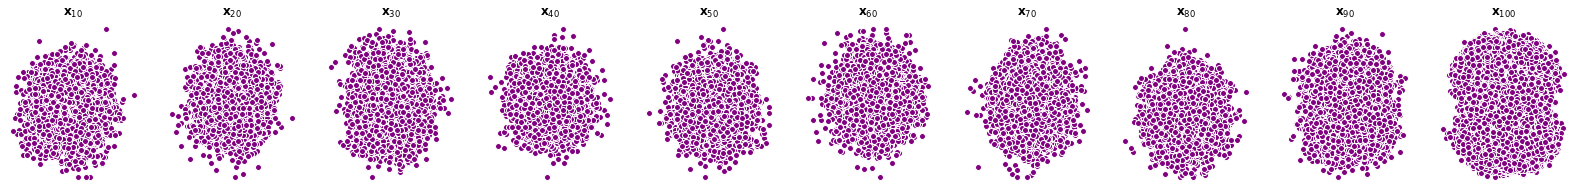

The loss at epoch 800 is 0.3453


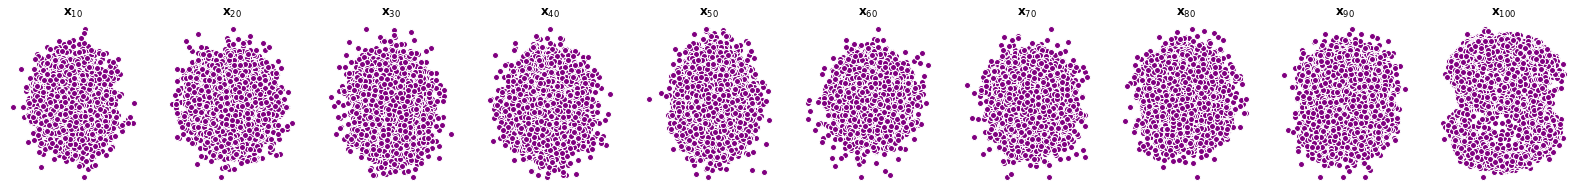

The loss at epoch 1200 is 0.1775


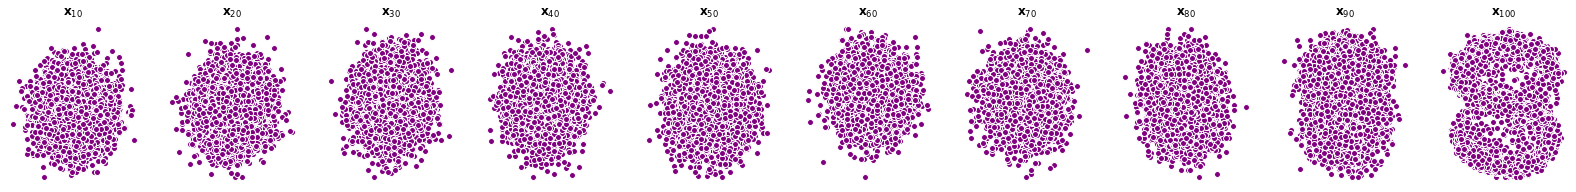

The loss at epoch 1600 is 0.1289


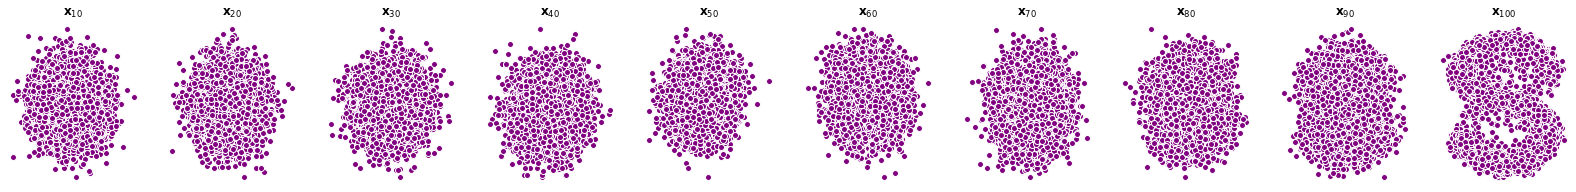

The loss at epoch 2000 is 0.0758


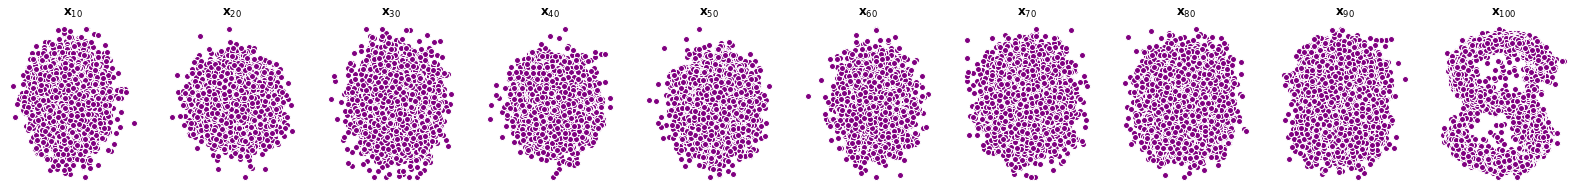

The loss at epoch 2400 is 0.1304


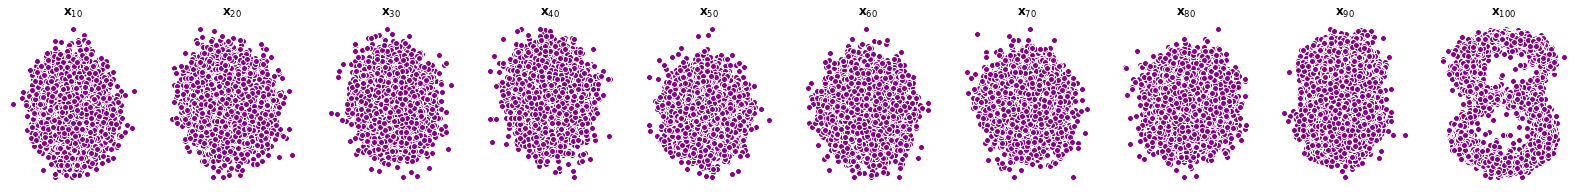

The loss at epoch 2800 is 0.1506


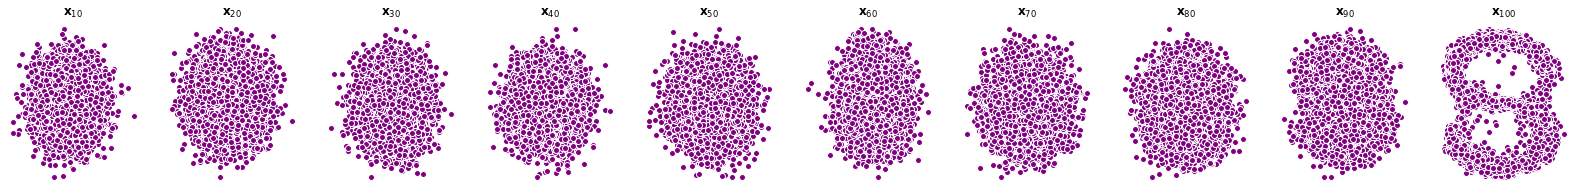

The loss at epoch 3200 is 0.0561


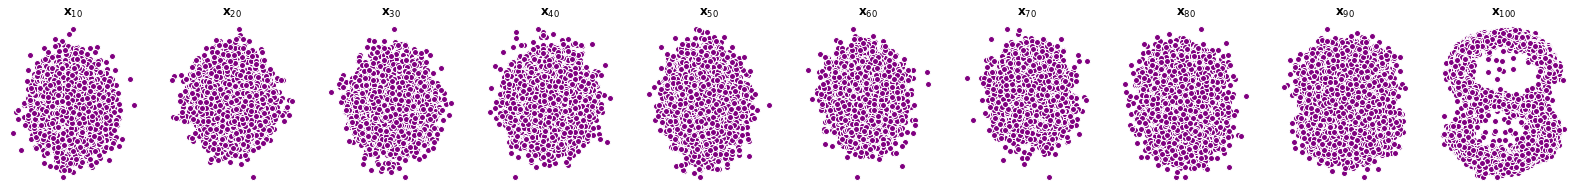

The loss at epoch 3600 is 0.1178


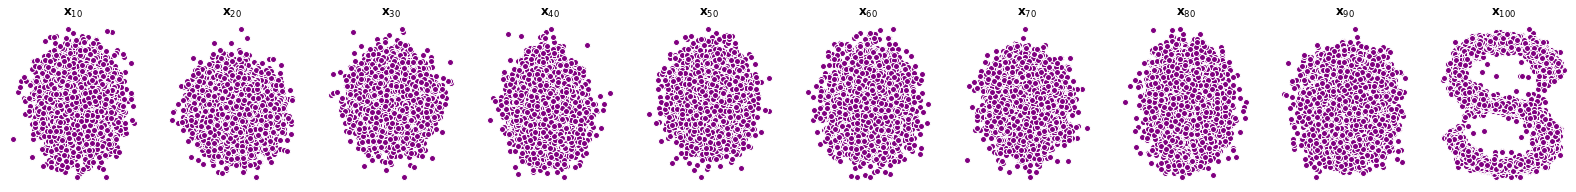

The loss at epoch 4000 is 0.1251


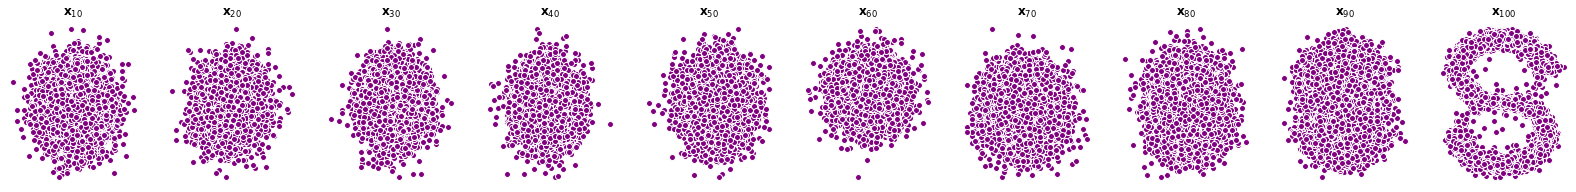

CPU times: total: 1h 24min 36s
Wall time: 3h 54min 43s


In [137]:
%%time 
#cell magics %% should start from the first line by convention
from torch.utils.data import DataLoader
print("Training model...")
batch_size = 128
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
num_epoch = 4000
num_shows = 10 # number of shows on each row

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
for epoch in range(num_epoch):
    for idx, x_batch in enumerate(dataloader):
        loss = diffusion_loss_fn(model,x_batch,num_steps)
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(),1.) # comment out this line? I will try the code without clipping grad.
        optimizer.step()
        
    if (epoch+1)%400==0:
        print("The loss at epoch %d is %.4f"%(epoch+1,loss.item()))
        x_seq = p_theta_sampling_loop(model,dataset.shape,num_steps)
        fig,ax = plt.subplots(1,num_shows,figsize=(28,3))
        step_size = num_steps//num_shows
        for i in range(num_shows):
            x = x_seq[(i+1)*step_size].detach()
            ax[i].scatter(*x.T,  color="purple", edgecolor="white")
            ax[i].set_axis_off()
            ax[i].set_title('$\mathbf{x}_{' +str((i+1)*step_size)+ '}$')
        plt.show()

In [ ]:
coef_x0*dataset[:100]

In [61]:
dataset[:100].shape

torch.Size([100, 2])

In [133]:
print(model)

MLPDiffusion(
  (Linears): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
  (step_embeddings): ModuleList(
    (0): Embedding(100, 128)
    (1): Embedding(100, 128)
    (2): Embedding(100, 128)
  )
)
